This notebook is intended to demonstrate how vessel segmentation methods of ITKTubeTK can be applied to multi-channel MRI (MRA + T1, T2, etc).

In [1]:
import itk
from itk import TubeTK as ttk

from itkwidgets import view

import numpy as np

In [2]:
#IMPORTANT: This assumed the data has been brain-stripped and resampled into isotropic spacing!!!
#The data used in these demos is generated by running the notebook "0-SegmentBrainFromMRIs.ipynb"

im1iso = itk.imread("MRA-Iso.mha")
im1Brain = itk.imread("MRA-Brain.mha")

im2iso = itk.imread("MRT1-Iso.mha")
im2Brain = itk.imread("MRT1-Brain.mha")

im3iso = itk.imread("MRT2-Iso.mha")
im3Brain = itk.imread("MRT2-Brain.mha")


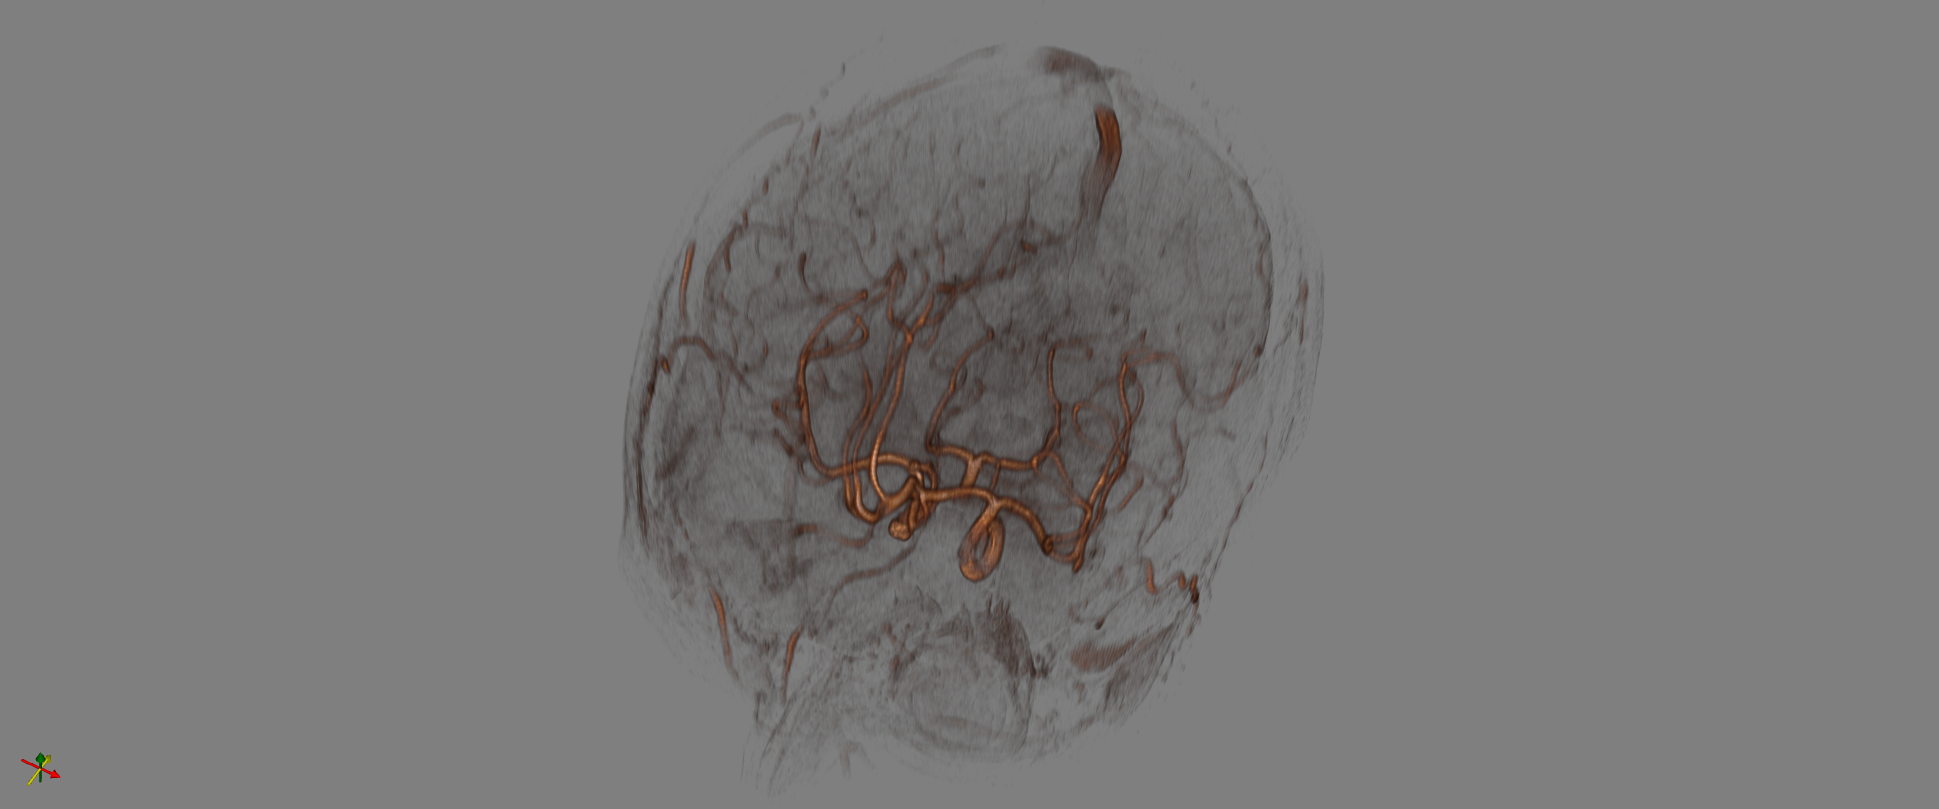
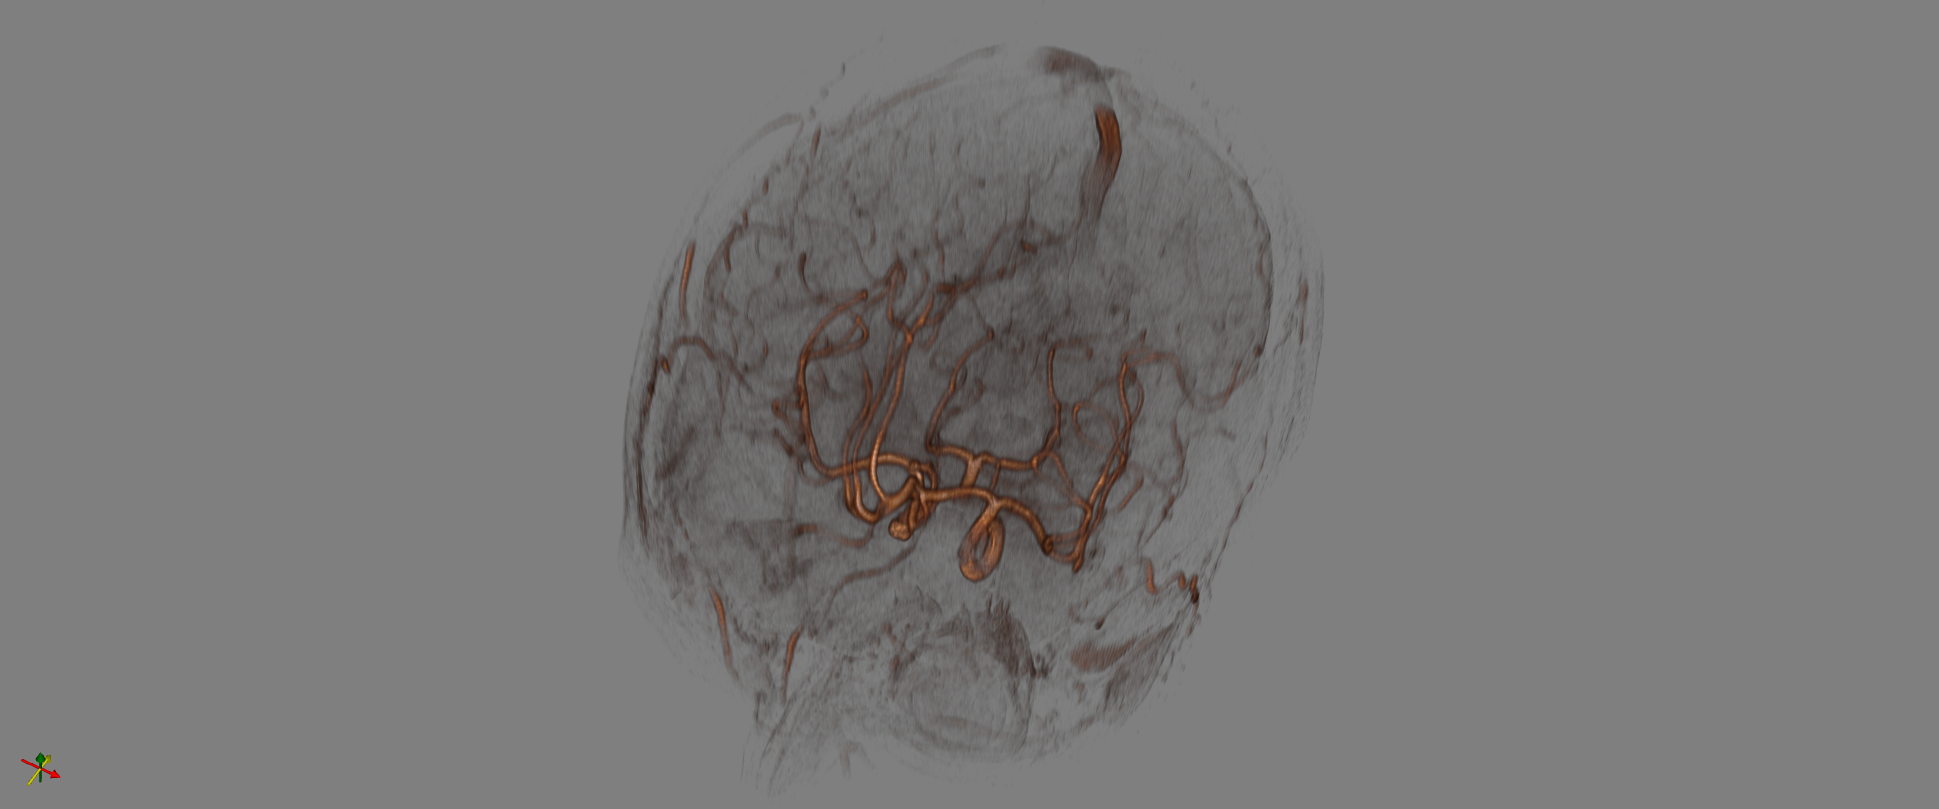

<IPython.core.display.Javascript object>

In [3]:
view(im1iso)

In [4]:
imMath = ttk.ImageMath.New(im1Brain)
imMath.Blur(1.0)
imBlur = imMath.GetOutput()
imBlurArray = itk.GetArrayViewFromImage(imBlur)

numSeeds = 10
seedCoverage = 20
seedCoord = np.zeros([numSeeds,3])
for i in range(numSeeds):
    seedCoord[i] = np.unravel_index(np.argmax(imBlurArray, axis=None), imBlurArray.shape)
    indx = [int(seedCoord[i][0]),int(seedCoord[i][1]),int(seedCoord[i][2])]
    minX = max(indx[0]-seedCoverage,0)
    maxX = max(indx[0]+seedCoverage,imBlurArray.shape[0])
    minY = max(indx[1]-seedCoverage,0)
    maxY = max(indx[1]+seedCoverage,imBlurArray.shape[1])
    minZ = max(indx[2]-seedCoverage,0)
    maxZ = max(indx[2]+seedCoverage,imBlurArray.shape[2])
    imBlurArray[minX:maxX,minY:maxY,minZ:maxZ]=0
    indx.reverse()
    seedCoord[:][i] = im1Brain.TransformIndexToPhysicalPoint(indx)
print(seedCoord)

itkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'itkImageF4'
vectoritkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'vectoritkImageF4'


[[ -2.659904  -5.245564 -28.937   ]
 [  9.517834 -16.163536 -25.187   ]
 [-11.478266 -27.50143  -36.437   ]
 [-21.556394 -19.10299  -22.687   ]
 [ -2.239982 -40.519012  -1.437   ]
 [-29.534912 -27.921352 -23.937   ]
 [ -5.179436 -54.79636   13.563   ]
 [-48.431402 -15.323692 -13.937   ]
 [-40.032962 -24.561976 -23.937   ]
 [ 32.193622 -51.436984 -18.937   ]]


In [5]:
# Manually extract a few vessels to form an image-specific training set
vSeg = ttk.SegmentTubes.New(im1iso)
vSeg.SetVerbose(True)
vSeg.SetMinRoundness(0.1)
vSeg.SetMinCurvature(0.001)
vSeg.SetRadiusInObjectSpace( 1 )
vSeg.SetMinLength(300)
for i in range(numSeeds):
    print("**** Processing seed " + str(i) + " : " + str(seedCoord[i]))
    vSeg.ExtractTubeInObjectSpace( seedCoord[i], i )
    
tubeMaskImage = vSeg.GetTubeMaskImage()

**** Processing seed 0 : [ -2.659904  -5.245564 -28.937   ]
**** Processing seed 1 : [  9.517834 -16.163536 -25.187   ]
**** Processing seed 2 : [-11.478266 -27.50143  -36.437   ]
**** Processing seed 3 : [-21.556394 -19.10299  -22.687   ]
**** Processing seed 4 : [ -2.239982 -40.519012  -1.437   ]
**** Processing seed 5 : [-29.534912 -27.921352 -23.937   ]
**** Processing seed 6 : [ -5.179436 -54.79636   13.563   ]
**** Processing seed 7 : [-48.431402 -15.323692 -13.937   ]
**** Processing seed 8 : [-40.032962 -24.561976 -23.937   ]
**** Processing seed 9 : [ 32.193622 -51.436984 -18.937   ]



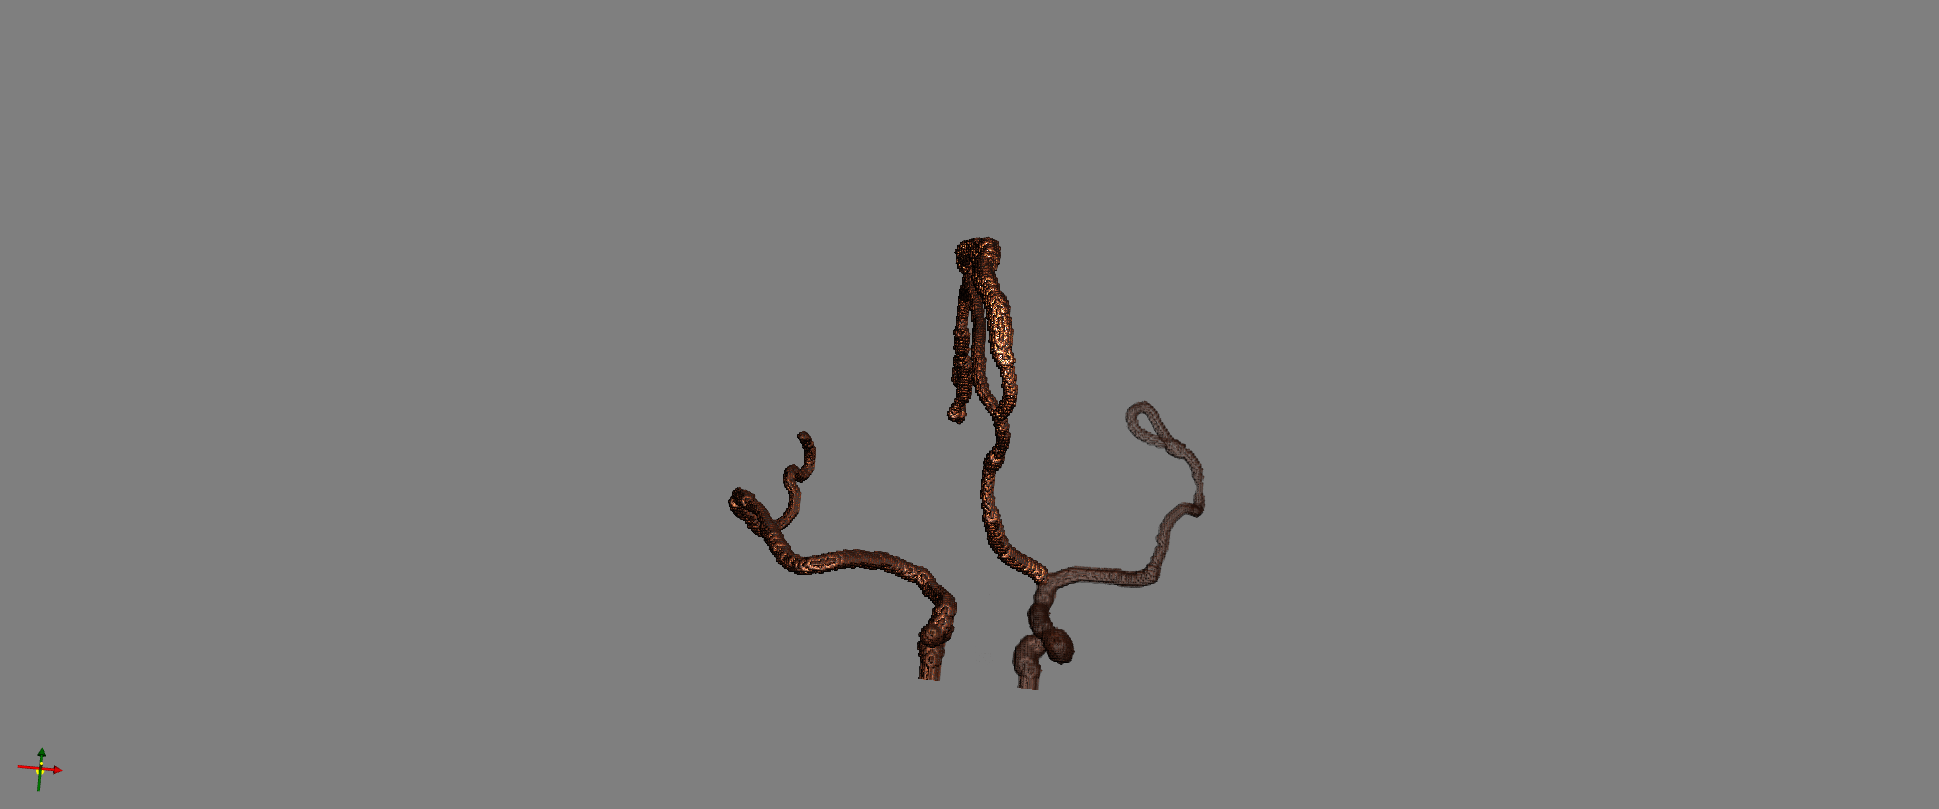
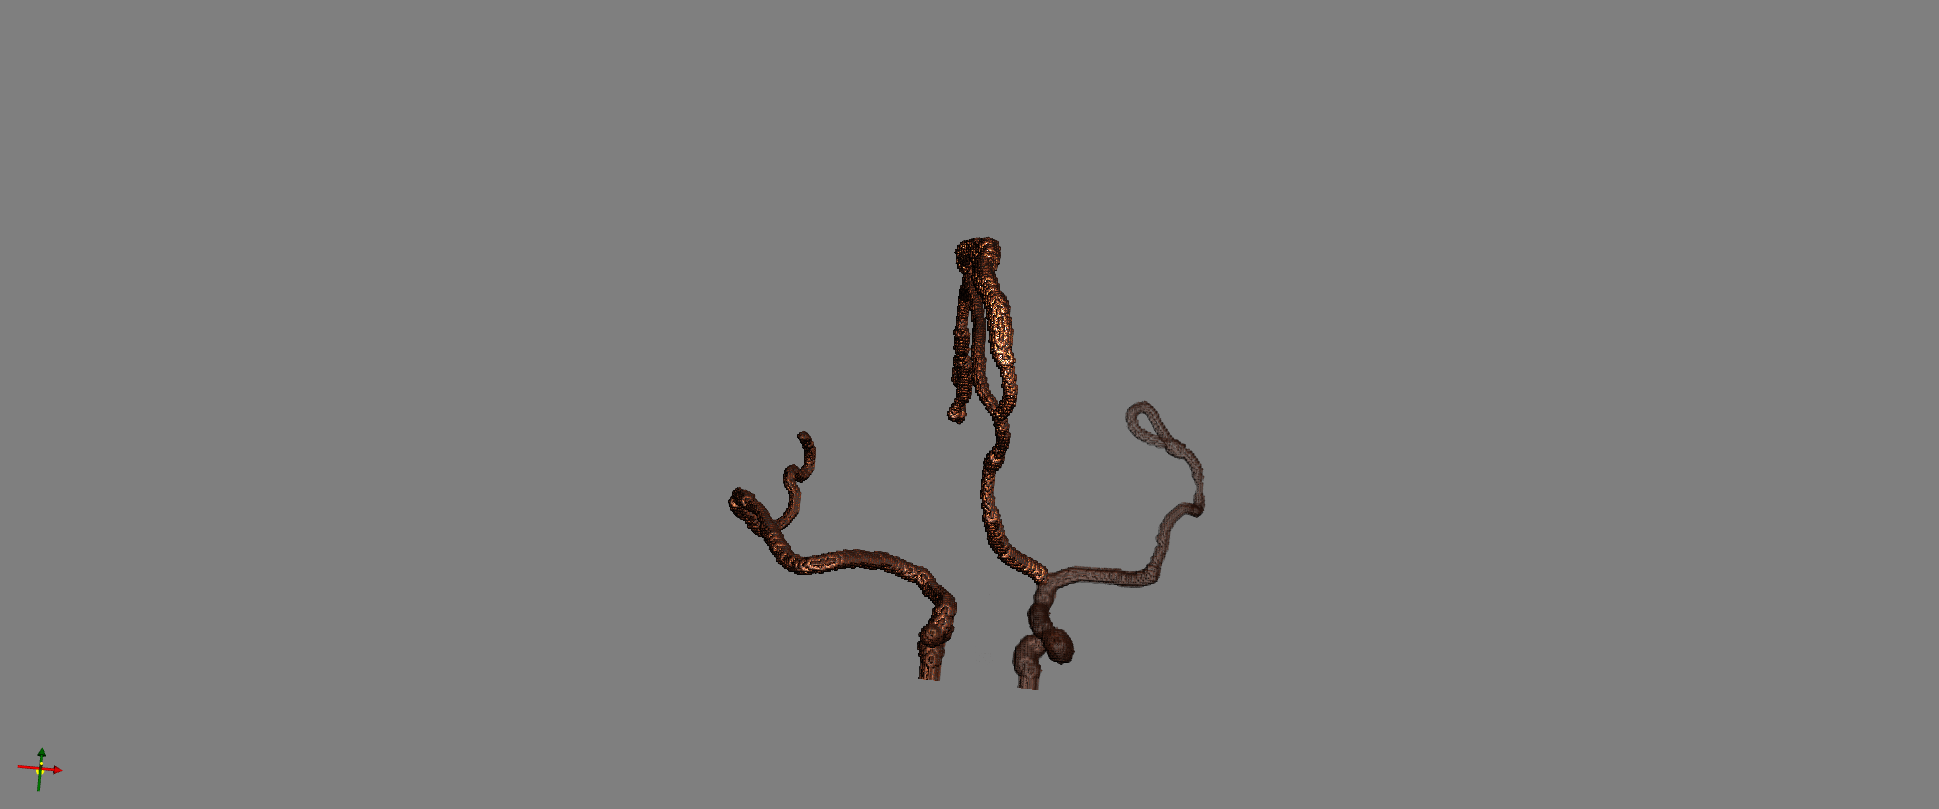

<IPython.core.display.Javascript object>

In [6]:
view(tubeMaskImage)

In [7]:
LabelMapType = itk.Image[itk.UC,3]

trMask = ttk.ComputeTrainingMask.New( tubeMaskImage )
trMask.SetGap( 3 )
trMask.SetObjectWidth( 1 )
trMask.SetNotObjectWidth( 1 )
trMask.Update()
fgMask = trMask.GetOutput()


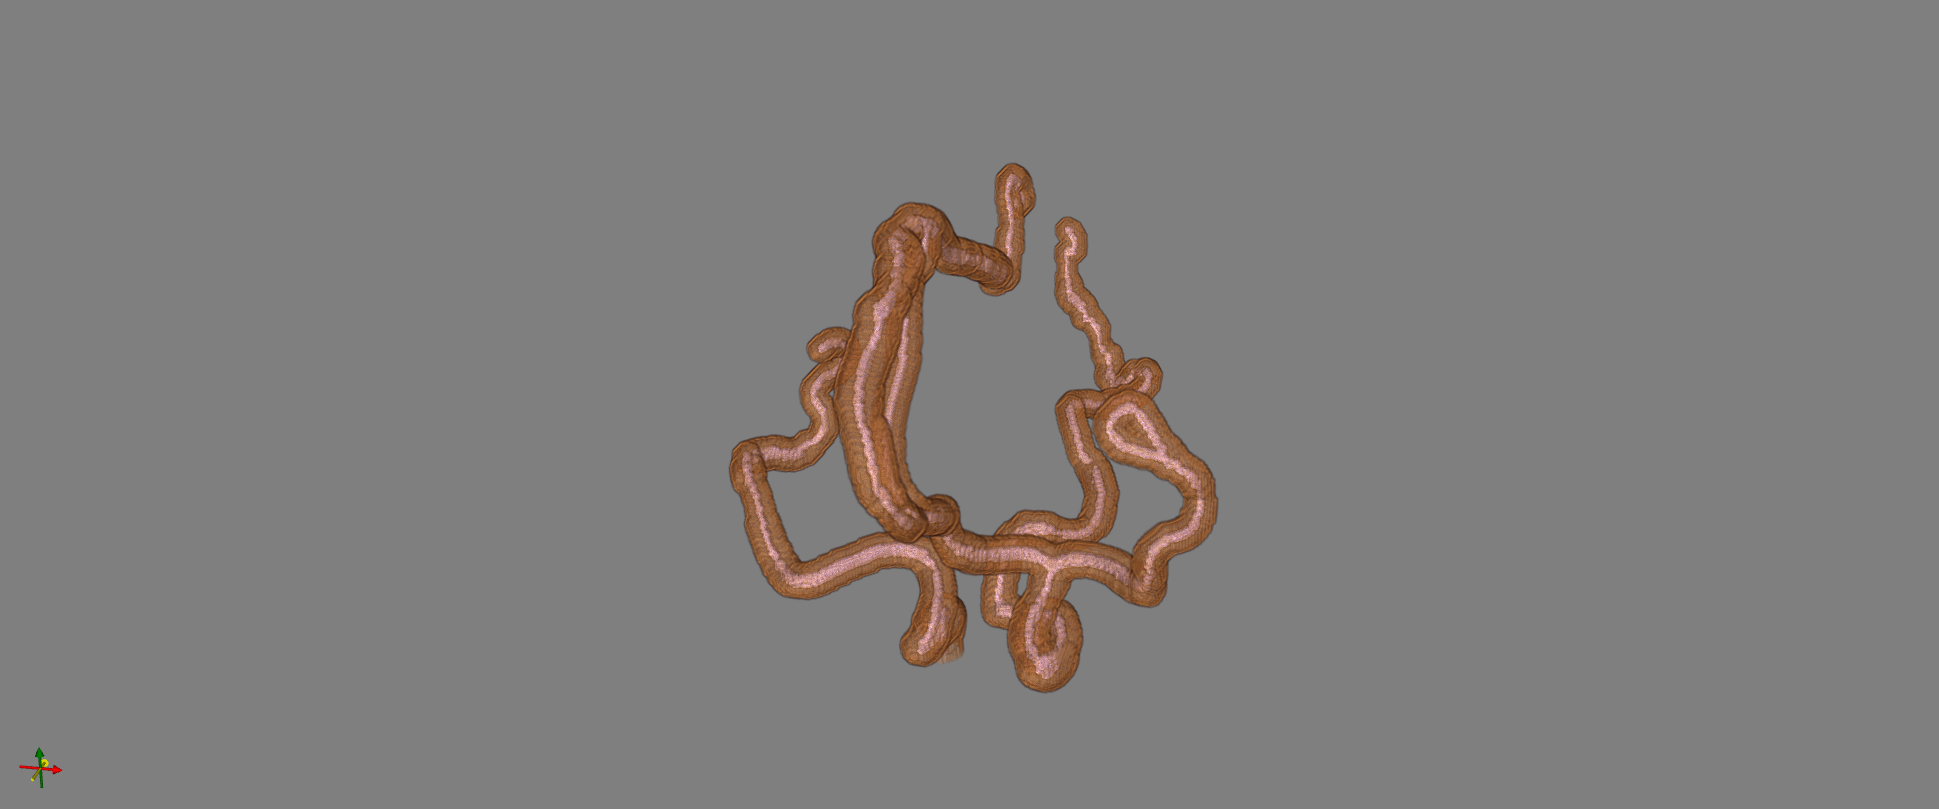
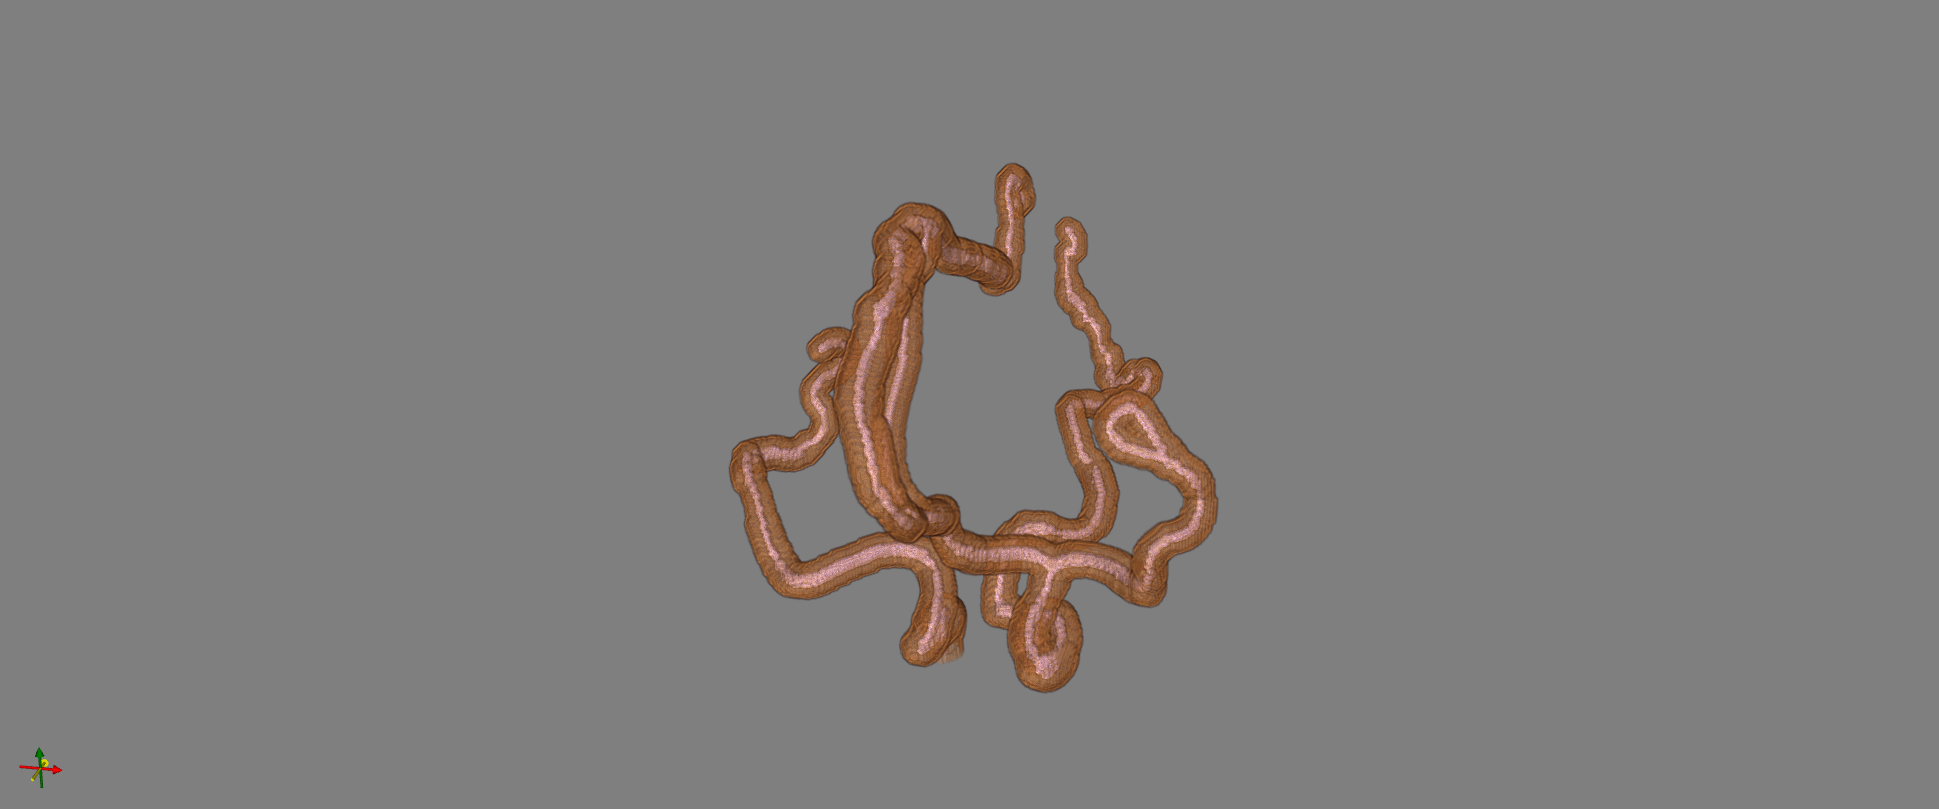

<IPython.core.display.Javascript object>

In [8]:
view(fgMask)

In [17]:
spacing = im1iso.GetSpacing()[0]

enhancer = ttk.EnhanceTubesUsingDiscriminantAnalysis.New( im1iso )
enhancer.AddInput( im2iso )
enhancer.AddInput( im3iso )
enhancer.SetLabelMap( fgMask )
enhancer.SetRidgeId( 255 )
enhancer.SetBackgroundId( 128 )
enhancer.SetUnknownId( 0 )
enhancer.SetTrainClassifier(True)
enhancer.SetUseIntensityOnly(True)
enhancer.SetScales([0.5*spacing,1*spacing,2*spacing])
enhancer.Update()
enhancer.ClassifyImages()

In [18]:
im1vess = itk.SubtractImageFilter( Input1=enhancer.GetClassProbabilityImage(0), Input2=enhancer.GetClassProbabilityImage(1))
view(im1vess)

<IPython.core.display.Javascript object>

In [19]:
itk.imwrite( im1vess, "MRA-VesselEnhanced.mha", compression=True)

brainMask = itk.imread( "MRMask-Brain.mha", itk.F )
im1BrainVess = itk.MultiplyImageFilter(Input1 = im1vess, Input2=brainMask)
itk.imwrite( im1BrainVess, "MRA-Brain-VesselEnhanced.mha", compression=True)


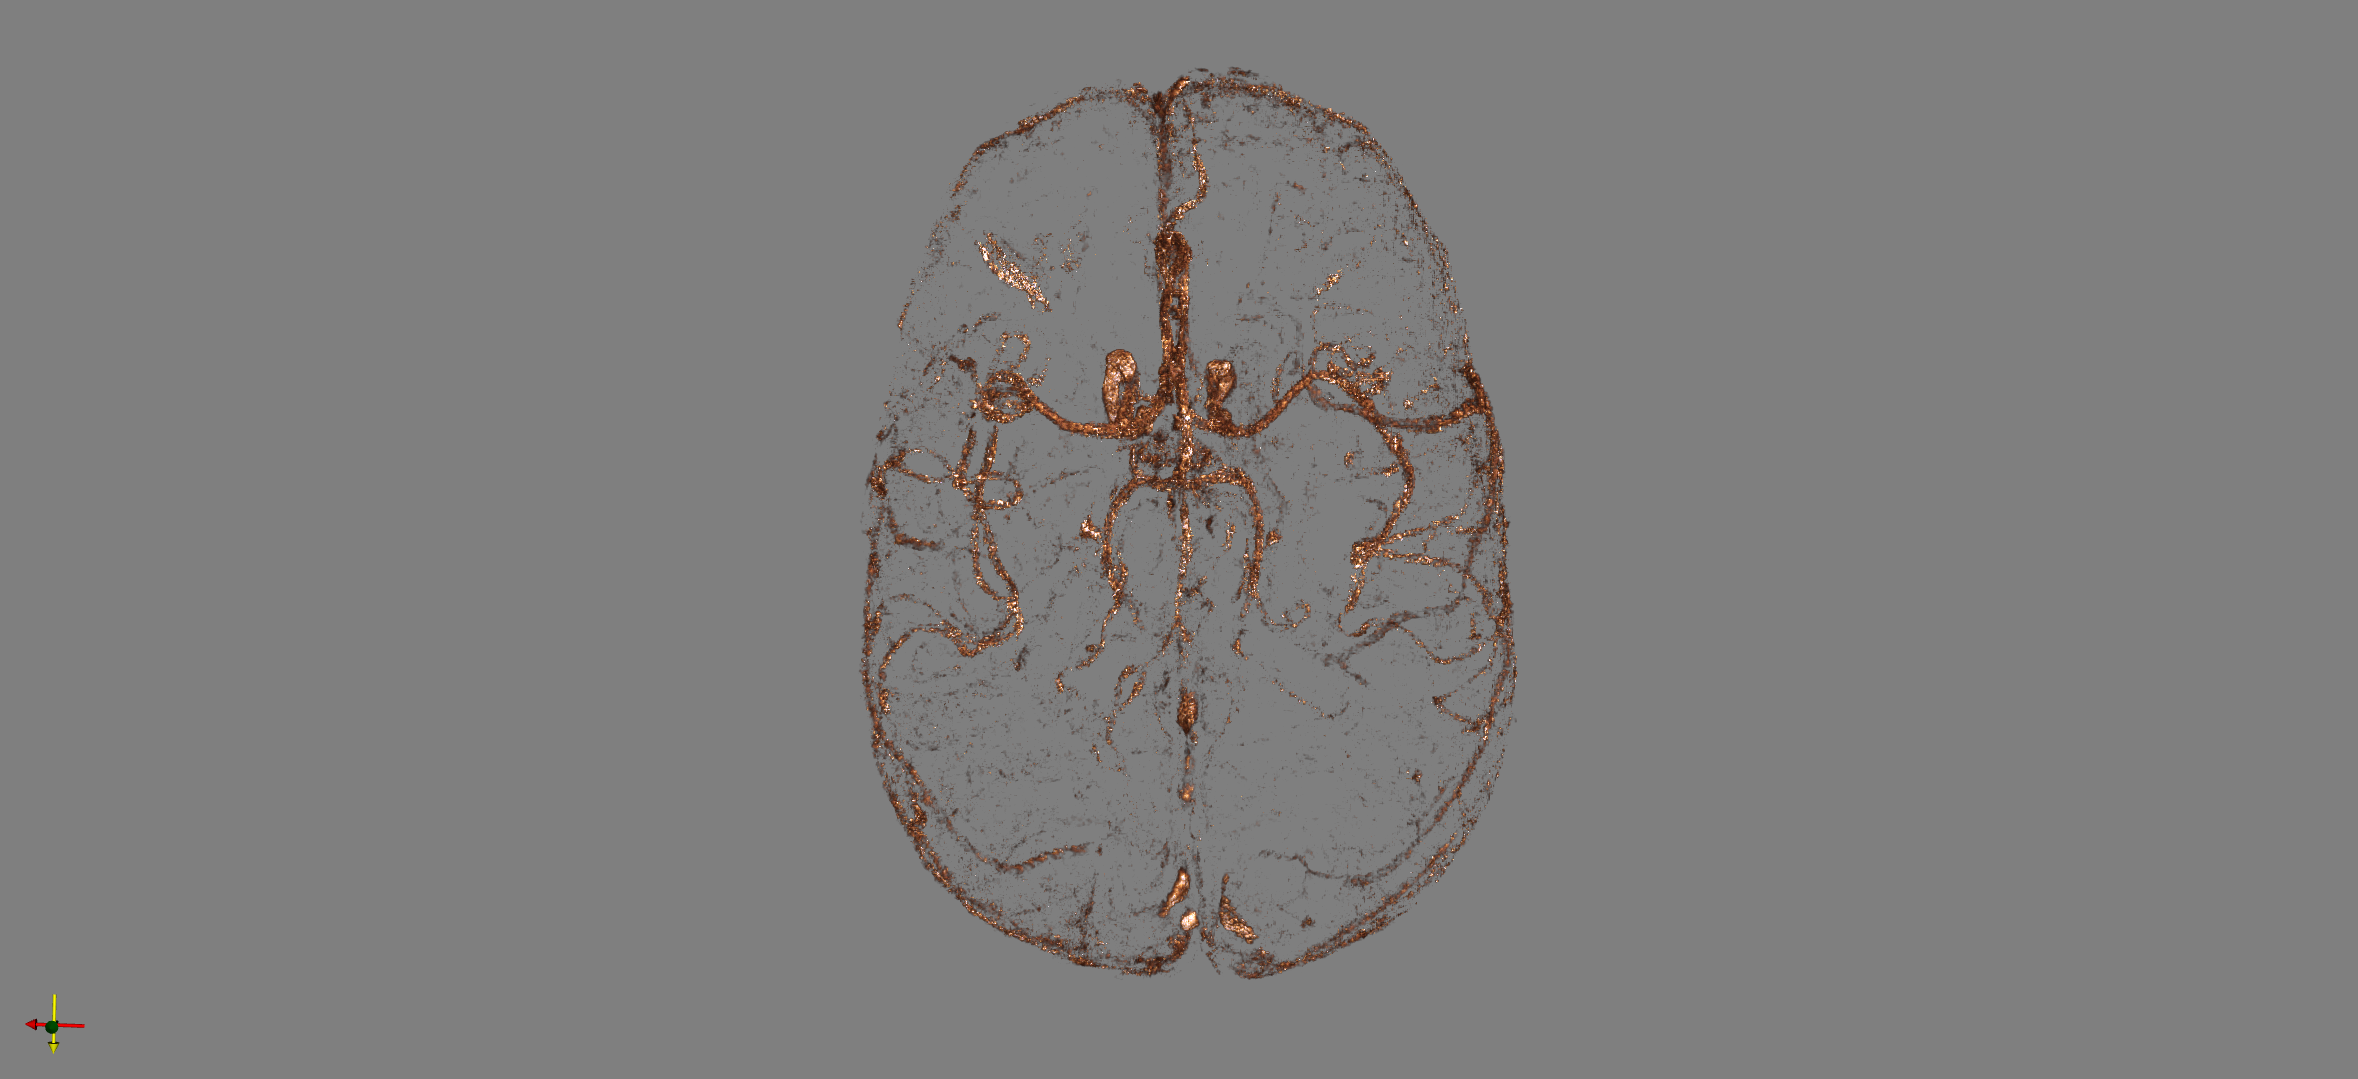
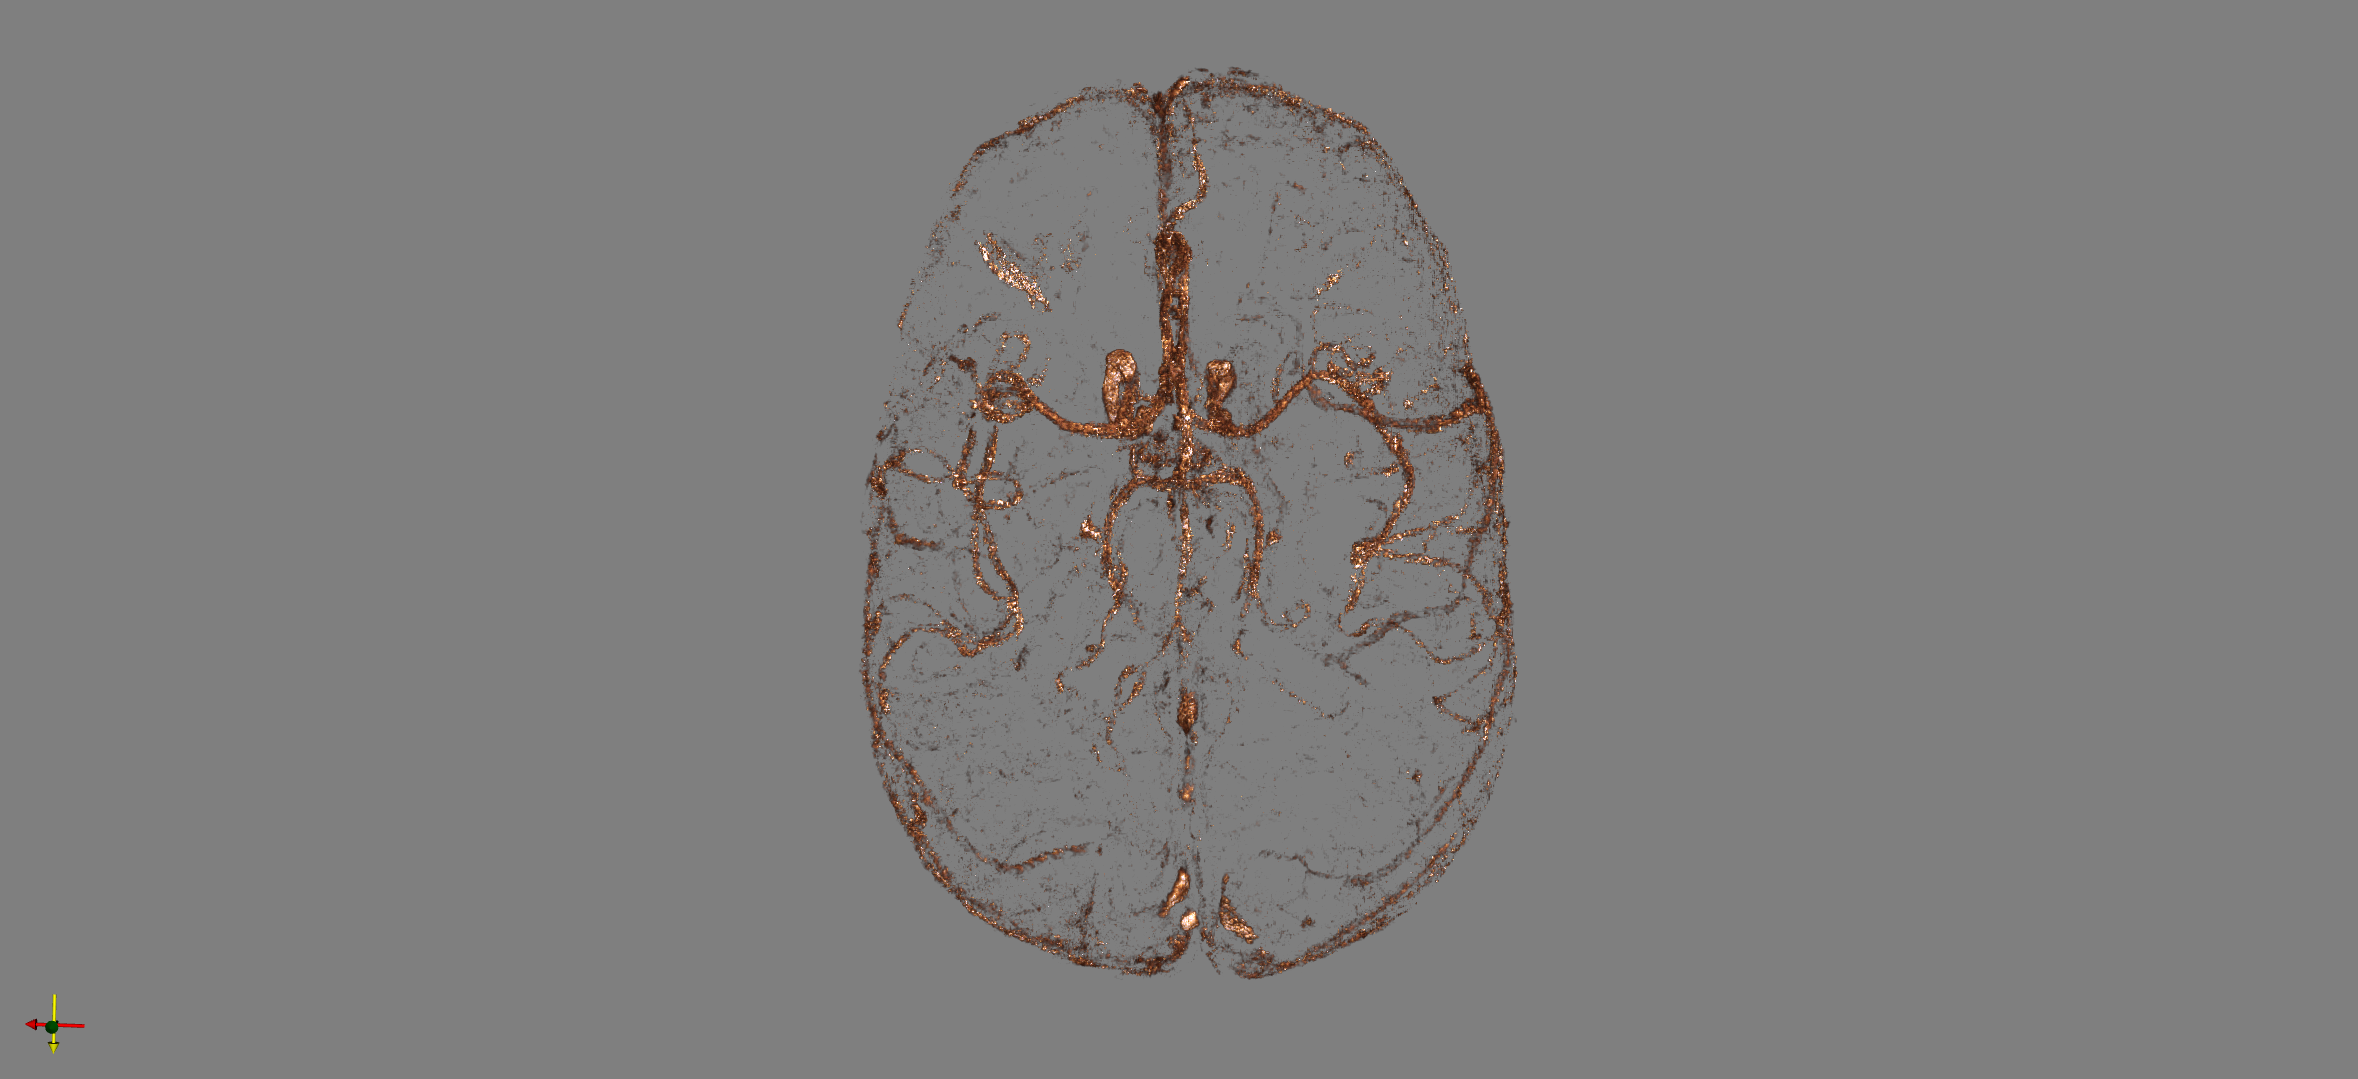

<IPython.core.display.Javascript object>

In [20]:
view(im1BrainVess)